In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]

In [6]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [7]:
df_encoded=df_encoded.dropna()

In [8]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [9]:
poly = PolynomialFeatures(2, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [10]:
scaler = PowerTransformer()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

In [11]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())


Explained variance ratio: 0.9817359009392069
Shape after PCA: (856, 100)
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -7.911739 -3.981658 -3.295656 -1.795017  1.155063 -2.514200 -0.877144   
1 -3.459694 -5.198033 -5.768154 -2.800029  3.191777 -1.058606 -0.091294   
2 -1.267748  7.778412  1.946123  0.580953  3.538997 -1.317817 -1.288940   
3  9.107580 -1.944740  6.071636  4.595493  1.591749 -0.061151  6.942428   
4 -2.061763  2.627465  2.243191 -0.211597  5.225609 -0.345405 -0.724801   

        PC8       PC9      PC10  ...      PC91      PC92      PC93      PC94  \
0 -0.199566 -0.143288  0.677746  ... -0.322203  0.192788 -0.055960 -0.450114   
1 -0.453705  0.105565  0.053366  ... -1.083106  0.407636 -0.155455 -0.481084   
2 -1.190651 -0.667865  0.892758  ...  0.221575  0.957459  0.425517 -0.418915   
3 -0.735806 -2.135882  2.444684  ... -0.275462 -0.185709 -0.213489 -0.600833   
4 -0.153156 -0.511625  0.047672  ...  0.521256 -0.050636 -0.308697  0.268912

In [12]:
X=X_pca_df

In [13]:
X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,-7.911739,-3.981658,-3.295656,-1.795017,1.155063,-2.514200,-0.877144,-0.199566,-0.143288,0.677746,...,-0.322203,0.192788,-0.055960,-0.450114,-0.300834,0.368508,0.524975,0.382958,-0.028419,-0.044039
1,-3.459694,-5.198033,-5.768154,-2.800029,3.191777,-1.058606,-0.091294,-0.453705,0.105565,0.053366,...,-1.083106,0.407636,-0.155455,-0.481084,-0.733750,0.415077,0.241855,0.718958,-0.057660,-0.180839
2,-1.267748,7.778412,1.946123,0.580953,3.538997,-1.317817,-1.288940,-1.190651,-0.667865,0.892758,...,0.221575,0.957459,0.425517,-0.418915,0.512222,-1.585024,-0.331960,0.248684,-0.072239,0.175337
3,9.107580,-1.944740,6.071636,4.595493,1.591749,-0.061151,6.942428,-0.735806,-2.135882,2.444684,...,-0.275462,-0.185709,-0.213489,-0.600833,0.477987,-0.195150,-0.128165,0.441831,0.011960,0.334274
4,-2.061763,2.627465,2.243191,-0.211597,5.225609,-0.345405,-0.724801,-0.153156,-0.511625,0.047672,...,0.521256,-0.050636,-0.308697,0.268912,-0.094482,-1.451071,0.316730,-1.059519,-1.073621,0.204940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,-6.021125,-5.018723,-4.393284,-2.529613,3.724996,0.903254,-0.030909,0.094553,-0.162509,0.042001,...,0.357629,-0.072149,-0.030930,0.165154,0.207407,-0.184500,-0.199811,-0.302473,0.110486,0.070624
852,-0.452237,9.004979,-3.993748,2.427086,-2.927296,7.296857,0.816447,-4.807896,3.424913,-1.282325,...,0.212807,-0.007527,-0.294024,0.220938,-0.188708,-0.107453,-0.104321,-0.431565,0.070422,0.221684
853,4.178891,-2.170521,-0.685473,-9.209700,0.656592,-2.973235,-0.103628,-0.101236,1.521421,0.114318,...,-0.096720,-0.419160,-0.090285,0.638212,0.363480,-0.095705,0.045818,-0.411916,0.301625,-0.061565
854,12.094734,-5.677509,-3.577943,3.318591,-6.374596,-4.769632,-9.024043,-4.228106,4.824025,-2.519075,...,-0.044582,0.382477,-0.028762,-0.214718,-0.133785,-0.076563,0.041288,0.343258,0.196238,-0.239506


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
     'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 25),
    'sampling_strategy': uniform(0.1, 0.6)
    #'max_leaf_nodes': randint(10, 100)
}

model = BalancedRandomForestClassifier(random_state=42, n_jobs=1, replacement=True, bootstrap=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,                  # number of random combinations to try
    #cv=ps,
    cv=4,
    scoring="average_precision",
    n_jobs=1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameters: {'max_depth': 48, 'min_samples_split': 24, 'n_estimators': 343, 'sampling_strategy': 0.45544874131722546}
Best score: 0.25274344108329827


In [16]:
y_pred=random_search.predict(X_test)
y_proba=random_search.predict_proba(X_test)[:,1]

In [17]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9763    0.9841    0.9802       251
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.9611       257
   macro avg     0.4881    0.4920    0.4901       257
weighted avg     0.9535    0.9611    0.9573       257



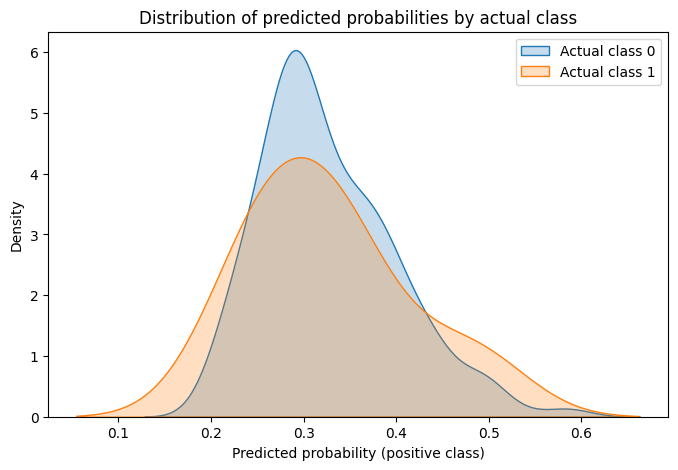

In [18]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()